In [1]:
import os
import numpy as np
import librosa
import librosa.display
import mido
import matplotlib.pyplot as plt
from glob import glob

def analyze_wav_onset(wav_path, plot=False):
    """
    Analyze WAV file to find the first significant onset time
    
    Args:
        wav_path: Path to the WAV file
        plot: Whether to generate plots for visualization
        
    Returns:
        first_onset_time: Time of the first significant onset in seconds
    """
    print(f"Analyzing WAV file: {wav_path}")
    
    # Load the audio file
    y, sr = librosa.load(wav_path)
    
    # Calculate onset strength
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    
    # Normalize onset strength
    onset_env_norm = librosa.util.normalize(onset_env)
    
    # Plot waveform for diagnostic purposes
    if plot:
        plt.figure(figsize=(12, 4))
        times = librosa.times_like(y, sr=sr)
        plt.plot(times, y)
        plt.title('Waveform')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.tight_layout()
    
    # Find onset peaks
    # Adjust parameters to fine-tune detection
    onset_frames = librosa.onset.onset_detect(
        onset_envelope=onset_env,
        sr=sr,
        wait=1,  # Minimum number of frames between consecutive onsets
        pre_max=1,
        post_max=1,
        pre_avg=1,
        post_avg=1,
        delta=0.3  # Use delta instead of threshold (threshold is passed to peak_pick)
    )
    
    # If no onsets detected, try with a lower delta
    if len(onset_frames) == 0:
        onset_frames = librosa.onset.onset_detect(
            onset_envelope=onset_env,
            sr=sr,
            delta=0.1
        )
    
    # If still no onsets, return None
    if len(onset_frames) == 0:
        print("No onsets detected in WAV file.")
        return None
    
    # If no onsets detected even with lower delta, try using RMS energy method
    if len(onset_frames) == 0:
        print("No onsets detected with standard method, trying energy-based detection...")
        # Calculate RMS energy
        rms = librosa.feature.rms(y=y)[0]
        # Find the first frame where RMS exceeds a threshold (e.g., 10% of max)
        threshold = 0.05 * np.max(rms)
        for i, energy in enumerate(rms):
            if energy > threshold:
                onset_frames = np.array([i])
                print(f"First significant energy detected at frame {i}")
                break
    
    # If still no onsets detected, return None
    if len(onset_frames) == 0:
        print("Warning: No significant audio onset could be detected.")
        return None
    
    # Get the first onset frame
    first_onset_frame = onset_frames[0]
    
    # Convert frame to time (handle scalar or array correctly)
    first_onset_time = librosa.frames_to_time(first_onset_frame, sr=sr)
    # If frames_to_time returns an array, take first element
    if isinstance(first_onset_time, np.ndarray):
        first_onset_time = first_onset_time[0]
    
    print(f"First significant audio onset at: {first_onset_time:.3f} seconds")
    
    # Optional visualization
    if plot:
        plt.figure(figsize=(12, 6))
        
        # Plot waveform
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.axvline(x=first_onset_time, color='r', linestyle='--', label=f'First Onset ({first_onset_time:.3f}s)')
        plt.title('Waveform with First Onset')
        plt.legend()
        
        # Plot onset strength
        plt.subplot(2, 1, 2)
        times = librosa.times_like(onset_env, sr=sr)
        plt.plot(times, onset_env_norm)
        plt.axvline(x=first_onset_time, color='r', linestyle='--')
        
        # Convert onset frames to times safely
        onset_times = librosa.frames_to_time(onset_frames, sr=sr)
        # Handle both scalar and array cases
        if not isinstance(onset_times, np.ndarray):
            onset_times = np.array([onset_times])
            
        plt.vlines(onset_times, 0, 1, color='g', alpha=0.7)
        plt.title('Onset Strength and Detected Onsets')
        plt.xlabel('Time (s)')
        plt.tight_layout()
        plt.savefig(os.path.splitext(wav_path)[0] + '_onset_analysis.png')
    
    return first_onset_time

def analyze_midi_onset(midi_path):
    """
    Analyze MIDI file to find the first note-on event time
    
    Args:
        midi_path: Path to the MIDI file
        
    Returns:
        first_note_time: Time of the first note-on event in seconds
    """
    print(f"Analyzing MIDI file: {midi_path}")
    
    try:
        # Load the MIDI file
        midi = mido.MidiFile(midi_path)
        
        first_note_time = None
        tempo = 500000  # Default tempo (microseconds per beat, equivalent to 120 BPM)
        
        # First pass: look for tempo information
        for track in midi.tracks:
            for msg in track:
                if msg.type == 'set_tempo':
                    tempo = msg.tempo
                    print(f"Found tempo: {60000000 / tempo:.1f} BPM")
                    break
            
        # Second pass: find first note event
        for track in midi.tracks:
            cumulative_time = 0  # in ticks
            
            # Process each message in the track
            for msg in track:
                cumulative_time += msg.time
                
                # Convert ticks to seconds
                seconds = mido.tick2second(cumulative_time, midi.ticks_per_beat, tempo)
                
                # Look for note_on events with velocity > 0
                if msg.type == 'note_on' and msg.velocity > 0:
                    if first_note_time is None or seconds < first_note_time:
                        first_note_time = seconds
        
        if first_note_time is not None:
            print(f"First MIDI note event at: {first_note_time:.3f} seconds")
            return first_note_time
        else:
            print("No note events found in MIDI file.")
            return None
            
    except Exception as e:
        print(f"Error reading MIDI file: {e}")
        return None

def check_sync(midi_path, wav_path, tolerance=0.05, plot=True):
    """
    Check synchronization between MIDI and WAV files
    
    Args:
        midi_path: Path to the MIDI file
        wav_path: Path to the WAV file
        tolerance: Tolerance in seconds for considering files synchronized
        plot: Whether to generate visualization plots
        
    Returns:
        is_synced: Boolean indicating whether files are in sync
        offset: Offset between MIDI and WAV (positive if WAV starts later)
    """
    # Get first onset times
    midi_onset_time = analyze_midi_onset(midi_path)
    wav_onset_time = analyze_wav_onset(wav_path, plot=plot)
    
    # Check if both analyses succeeded
    if midi_onset_time is None or wav_onset_time is None:
        print("Could not determine sync status due to detection failure")
        return False, None
    
    # Calculate offset (positive if WAV starts later than MIDI)
    offset = wav_onset_time - midi_onset_time
    
    # Check if within tolerance
    is_synced = abs(offset) <= tolerance
    
    # Output result
    if is_synced:
        print(f"✅ Files are synchronized (offset: {offset:.3f}s, within tolerance of {tolerance:.3f}s)")
    else:
        print(f"❌ Files are NOT synchronized (offset: {offset:.3f}s, exceeds tolerance of {tolerance:.3f}s)")
        
        # Recommend correction
        if offset > 0:
            print(f"  → The WAV file starts {offset:.3f}s AFTER the MIDI file")
            print(f"  → Suggestion: Trim {offset:.3f}s from the beginning of the WAV file OR")
            print(f"                Add {offset:.3f}s delay to the MIDI file")
        else:
            print(f"  → The WAV file starts {abs(offset):.3f}s BEFORE the MIDI file")
            print(f"  → Suggestion: Trim {abs(offset):.3f}s from the beginning of the MIDI file OR")
            print(f"                Add {abs(offset):.3f}s silence to the beginning of the WAV file")
            
    return is_synced, offset

def batch_check_sync(folder_path, tolerance=0.05, plot=False):
    """
    Check sync for all MIDI-WAV pairs in a folder
    
    Args:
        folder_path: Path to folder containing MIDI and WAV files
        tolerance: Tolerance in seconds for considering files synchronized
        plot: Whether to generate visualization plots
    """
    print(f"Analyzing all MIDI-WAV pairs in: {folder_path}")
    
    # Get all MIDI files
    midi_files = glob(os.path.join(folder_path, "*.mid"))
    results = []
    
    for midi_path in midi_files:
        # Find corresponding WAV file
        base_name = os.path.splitext(os.path.basename(midi_path))[0]
        wav_path = os.path.join(folder_path, base_name + ".wav")
        
        # Check if WAV file exists
        if os.path.exists(wav_path):
            print("\n" + "="*50)
            print(f"Checking pair: {base_name}")
            is_synced, offset = check_sync(midi_path, wav_path, tolerance, plot)
            
            results.append({
                "name": base_name,
                "midi_path": midi_path,
                "wav_path": wav_path,
                "is_synced": is_synced,
                "offset": offset
            })
        else:
            print(f"No matching WAV file for: {midi_path}")
    
    # Print summary
    print("\n" + "="*50)
    print(f"Synchronization analysis complete for {len(results)} pairs")
    synced_count = sum(1 for r in results if r["is_synced"])
    print(f"✅ {synced_count} pairs synchronized (within {tolerance:.3f}s tolerance)")
    print(f"❌ {len(results) - synced_count} pairs NOT synchronized")
    
    # Return the results for further analysis
    return results



In [2]:
if __name__ == "__main__":
    # Example usage for a single pair
    midi_file = "/Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.mid"
    wav_file = "/Users/macbookpro/Downloads/tdg_notebooks/1_funk_80_beat_4-4_synced.wav"
    
    check_sync(midi_file, wav_file, tolerance=0.05, plot=True)
    
    # For batch processing of all files in a folder
    # batch_check_sync("/Users/macbookpro/Downloads/groove/drummer1/session1", tolerance=0.05)

Analyzing MIDI file: /Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.mid
Error reading MIDI file: [Errno 2] No such file or directory: '/Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.mid'
Analyzing WAV file: /Users/macbookpro/Downloads/tdg_notebooks/1_funk_80_beat_4-4_synced.wav


/var/folders/b9/t4lk8c451h5dmb3m5570wjvc0000gn/T/ipykernel_2199/2439644788.py:23: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(wav_path)
/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/macbookpro/Downloads/tdg_notebooks/1_funk_80_beat_4-4_synced.wav'


==== Synchronization Iteration 1/3 ====
Analyzing MIDI file: /Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.mid
Found tempo: 80.0 BPM
First MIDI note event at: 2.116 seconds
Analyzing WAV file: /Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.wav
First significant audio onset at: 4.319 seconds
❌ Files are NOT synchronized (offset: 2.203s, exceeds tolerance of 0.050s)
  → The WAV file starts 2.203s AFTER the MIDI file
  → Suggestion: Trim 2.203s from the beginning of the WAV file OR
                Add 2.203s delay to the MIDI file
Trimming 2.203 seconds from the beginning of 1_funk_80_beat_4-4.wav
Saved trimmed file to /Users/macbookpro/Downloads/tdg_notebooks/1_funk_80_beat_4-4_iter1.wav

==== Synchronization Iteration 2/3 ====
Analyzing MIDI file: /Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.mid
Found tempo: 80.0 BPM
First MIDI note event at: 2.116 seconds
Analyzing WAV file: /Users/macbookpro/Downloads/tdg_n

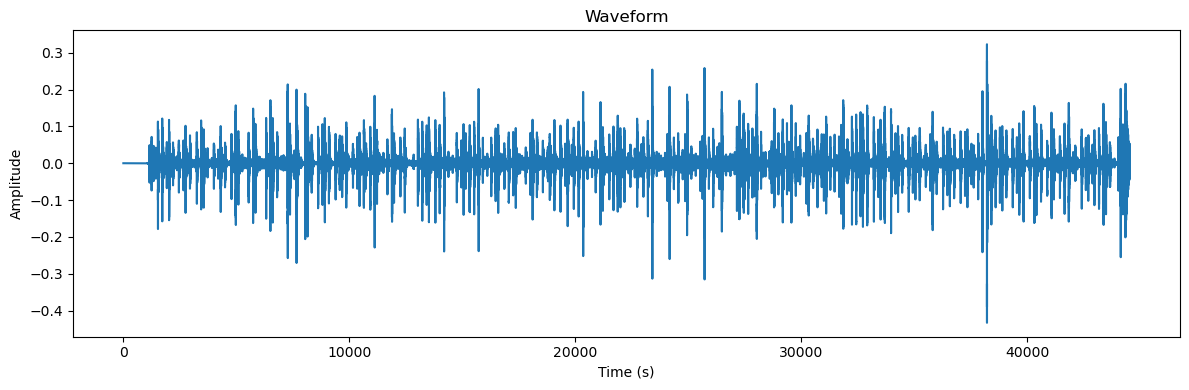

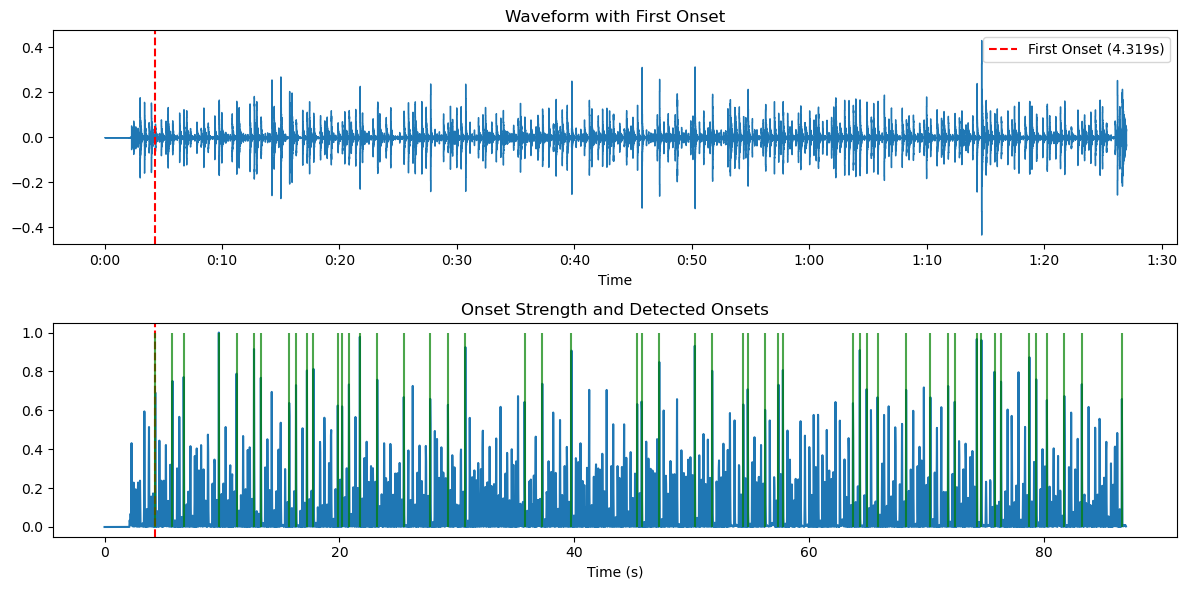

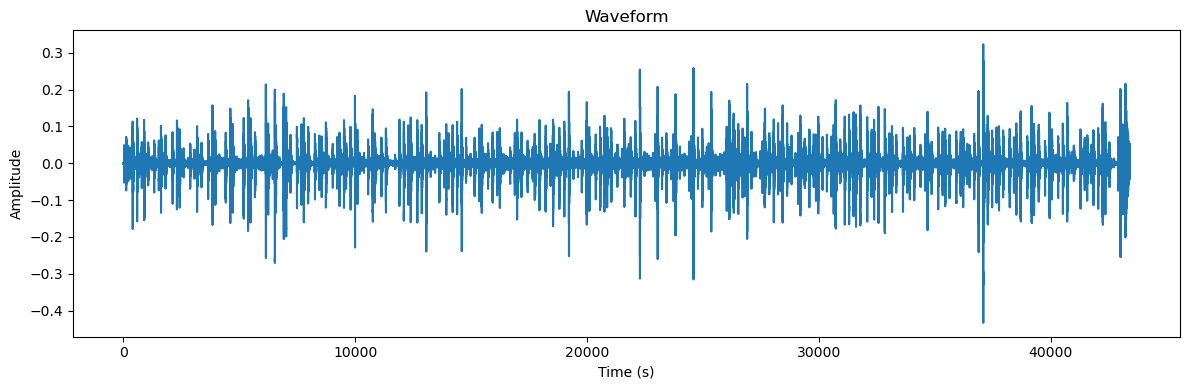

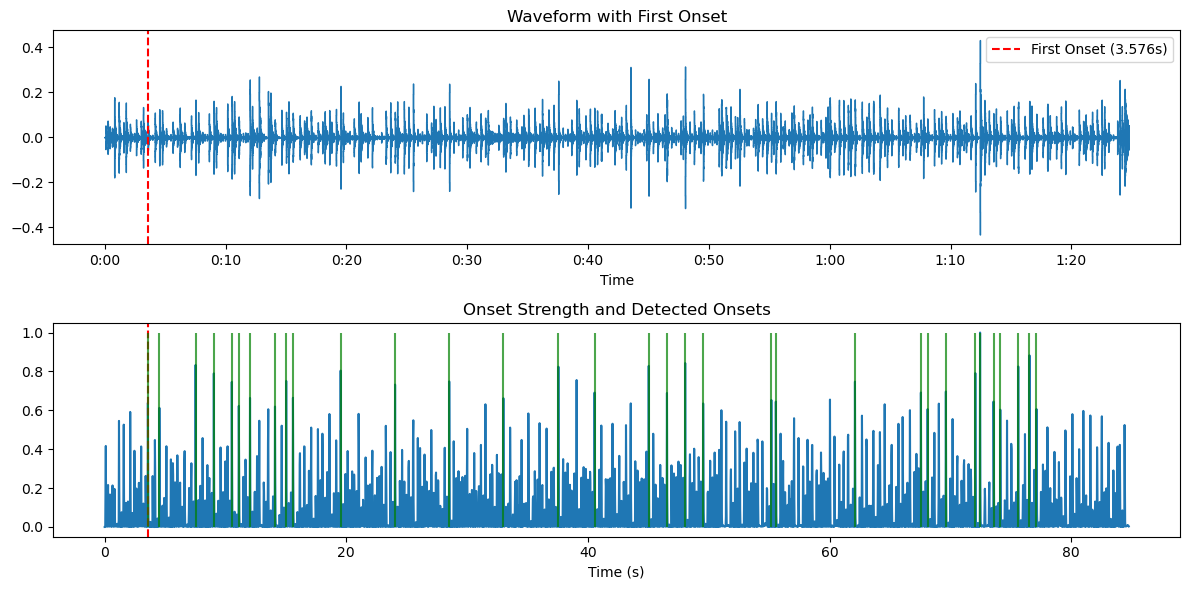

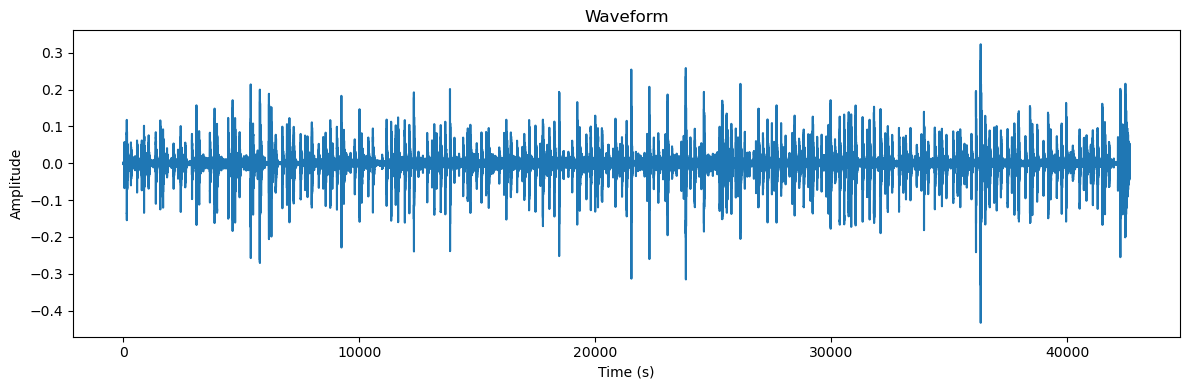

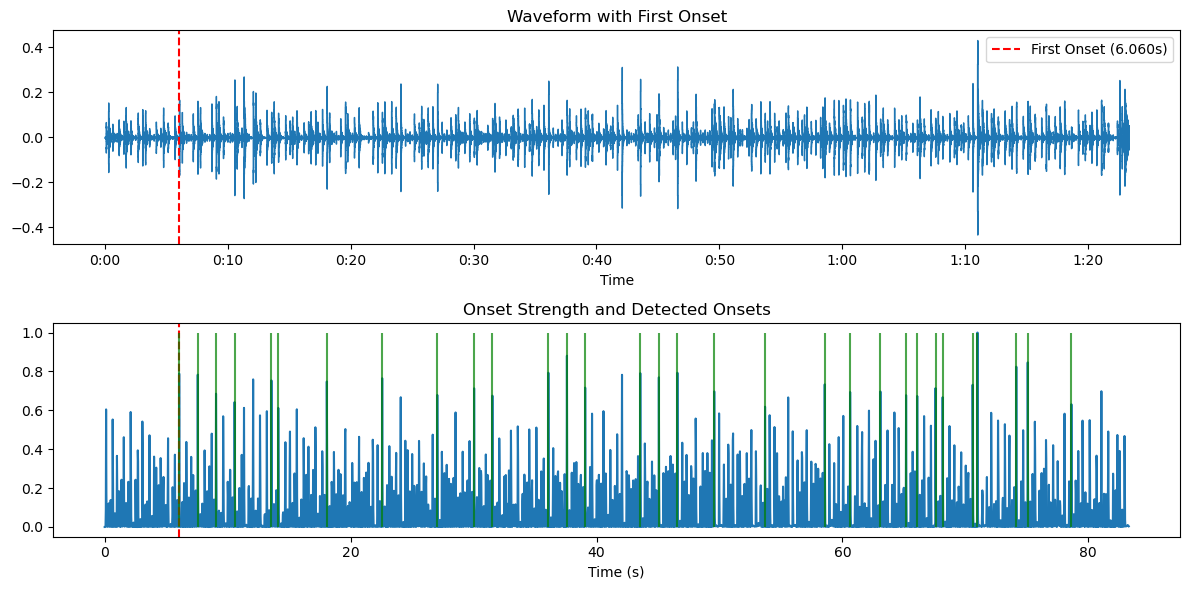

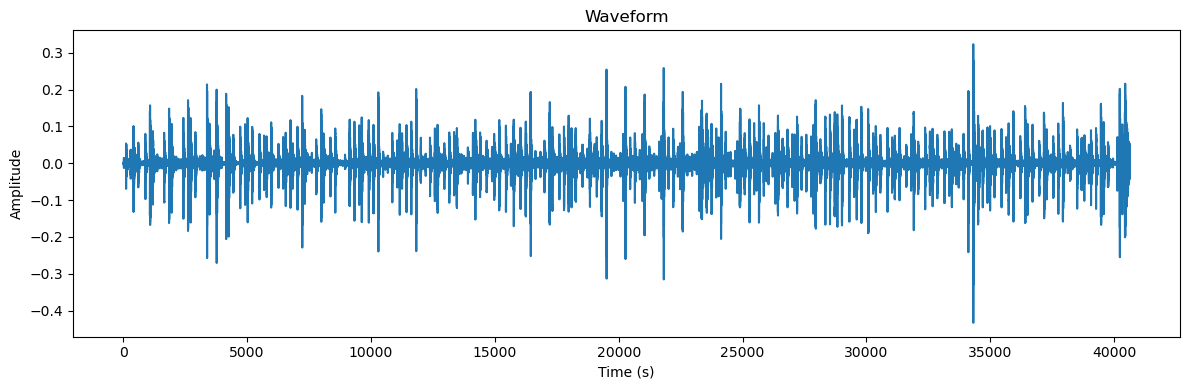

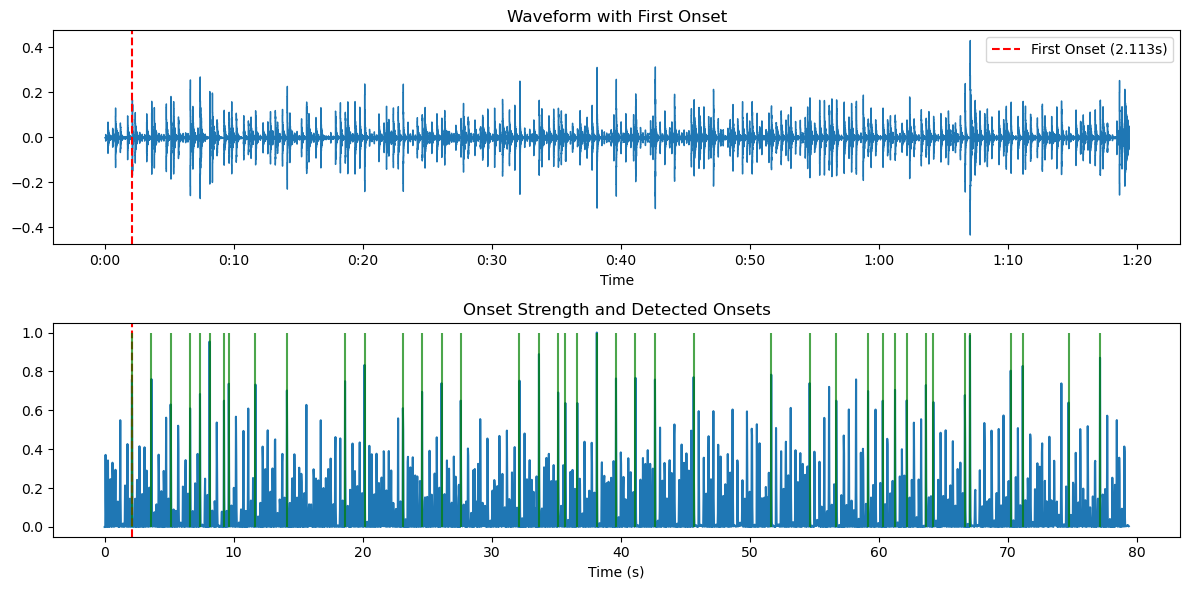

In [ ]:
import os
import numpy as np
import librosa
import soundfile as sf
import mido
import matplotlib.pyplot as plt
from glob import glob


def trim_wav_file(wav_path, output_path, trim_seconds):
    """
    Trim the beginning of a WAV file by the specified number of seconds
    """
    print(f"Trimming {trim_seconds:.3f} seconds from the beginning of {os.path.basename(wav_path)}")
    
    # Load the audio file
    y, sr = librosa.load(wav_path, sr=None)  # Use original sample rate
    
    # Calculate the number of samples to trim
    trim_samples = int(trim_seconds * sr)
    
    # Ensure we don't try to trim more samples than we have
    if trim_samples >= len(y):
        print(f"Error: Cannot trim {trim_seconds:.3f}s as the file is only {len(y)/sr:.3f}s long")
        return None
    
    # Trim the audio
    y_trimmed = y[trim_samples:]
    
    # Save the trimmed audio
    sf.write(output_path, y_trimmed, sr)
    print(f"Saved trimmed file to {output_path}")
    
    return output_path

def iterative_sync(midi_path, wav_path, output_dir=None, max_iterations=3, tolerance=0.05, plot=True):
    """
    Iteratively synchronize a MIDI-WAV pair until they are properly aligned
    
    Args:
        midi_path: Path to the MIDI file
        wav_path: Path to the original WAV file
        output_dir: Directory to save synchronized files
        max_iterations: Maximum number of synchronization attempts
        tolerance: Tolerance in seconds for considering files synchronized
        plot: Whether to generate visualization plots
        
    Returns:
        final_wav_path: Path to the final synchronized WAV file
        total_trim: Total amount of time trimmed from the original WAV file
    """
    # Set up output directory
    if output_dir is None:
        output_dir = os.path.dirname(wav_path)
    os.makedirs(output_dir, exist_ok=True)
    
    # Get base filename
    base_name = os.path.splitext(os.path.basename(wav_path))[0]
    
    # Initialize tracking variables
    current_wav = wav_path
    current_iteration = 0
    total_trim = 0
    success = False
    
    while current_iteration < max_iterations and not success:
        current_iteration += 1
        print(f"\n==== Synchronization Iteration {current_iteration}/{max_iterations} ====")
        
        # Check current synchronization
        is_synced, offset = check_sync(midi_path, current_wav, tolerance, plot=plot)
        
        # If already synchronized or unable to determine offset, break
        if is_synced:
            print(f"✅ Files are now synchronized (within {tolerance:.3f}s tolerance)")
            success = True
            break
            
        if offset is None:
            print("⚠️ Unable to determine offset. Stopping iterations.")
            break
            
        # If WAV starts after MIDI, trim it
        if offset > 0:
            # Create output path for this iteration
            if current_iteration == max_iterations:
                # Final output
                output_wav = os.path.join(output_dir, f"{base_name}_synced.wav")
            else:
                # Intermediate output
                output_wav = os.path.join(output_dir, f"{base_name}_iter{current_iteration}.wav")
            
            # Trim the WAV file
            new_wav = trim_wav_file(current_wav, output_wav, offset)
            
            # Update tracking variables
            if new_wav is not None:
                current_wav = new_wav
                total_trim += offset
            else:
                print("⚠️ Trimming failed. Stopping iterations.")
                break
        else:
            print(f"⚠️ WAV starts before MIDI by {abs(offset):.3f}s. Cannot trim negative time.")
            break
    
    # Final check and report
    if current_iteration >= max_iterations and not success:
        print(f"\n⚠️ Maximum iterations ({max_iterations}) reached.")
        is_synced, final_offset = check_sync(midi_path, current_wav, tolerance, plot=plot)
        if is_synced:
            print(f"✅ Files are now synchronized (within {tolerance:.3f}s tolerance)")
            success = True
        else:
            print(f"❌ Files are still not synchronized (offset: {final_offset:.3f}s)")
    
    # Ensure the final file has the _synced suffix
    if success and not current_wav.endswith("_synced.wav"):
        final_wav = os.path.join(output_dir, f"{base_name}_synced.wav")
        if current_wav != final_wav:
            import shutil
            shutil.copy(current_wav, final_wav)
            print(f"Copied final synchronized file to {final_wav}")
            current_wav = final_wav
    
    print(f"\n==== Synchronization Summary ====")
    print(f"Original WAV: {wav_path}")
    print(f"Final WAV: {current_wav}")
    print(f"Total time trimmed: {total_trim:.3f} seconds")
    print(f"Synchronized: {'Yes' if success else 'No'}")
    
    return current_wav, total_trim, success

if __name__ == "__main__":
    # Example usage
    midi_file = "/Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.mid"
    wav_file = "/Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.wav"
    output_dir = "/Users/macbookpro/Downloads/tdg_notebooks"
    
    # Run iterative synchronization
    final_wav, total_trim, success = iterative_sync(midi_file, wav_file, output_dir, max_iterations=3)

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import mido
import matplotlib.pyplot as plt

def get_first_midi_note_time(midi_path):
    """
    Get the time of the first note in a MIDI file
    
    Args:
        midi_path: Path to the MIDI file
        
    Returns:
        first_note_time: Time of first note in seconds
    """
    print(f"Analyzing MIDI file: {midi_path}")
    
    try:
        # Load the MIDI file
        midi = mido.MidiFile(midi_path)
        
        first_note_time = None
        tempo = 500000  # Default tempo (microseconds per beat, equivalent to 120 BPM)
        
        # First pass: look for tempo information
        for track in midi.tracks:
            for msg in track:
                if msg.type == 'set_tempo':
                    tempo = msg.tempo
                    print(f"Found tempo: {60000000 / tempo:.1f} BPM")
                    break
            
        # Second pass: find first note event
        for track in midi.tracks:
            cumulative_time = 0  # in ticks
            
            # Process each message in the track
            for msg in track:
                cumulative_time += msg.time
                
                # Convert ticks to seconds
                seconds = mido.tick2second(cumulative_time, midi.ticks_per_beat, tempo)
                
                # Look for note_on events with velocity > 0
                if msg.type == 'note_on' and msg.velocity > 0:
                    if first_note_time is None or seconds < first_note_time:
                        first_note_time = seconds
        
        if first_note_time is not None:
            print(f"First MIDI note event at: {first_note_time:.3f} seconds")
            return first_note_time
        else:
            print("No note events found in MIDI file.")
            return None
            
    except Exception as e:
        print(f"Error reading MIDI file: {e}")
        return None

def get_first_wav_onset(wav_path, plot=False):
    """
    Get the time of the first significant onset in a WAV file
    
    Args:
        wav_path: Path to the WAV file
        plot: Whether to generate visualization plots
        
    Returns:
        first_onset_time: Time of first significant onset in seconds
    """
    print(f"Analyzing WAV file: {wav_path}")
    
    # Load the audio file
    y, sr = librosa.load(wav_path, sr=None)
    
    # Calculate onset strength
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    
    # Find onset peaks using multiple methods to ensure robustness
    # Method 1: Standard onset detection
    onset_frames = librosa.onset.onset_detect(
        onset_envelope=onset_env,
        sr=sr,
        delta=0.3,  # Adjust based on audio characteristics
        wait=1
    )
    
    # If no onsets detected, try with a lower delta
    if len(onset_frames) == 0:
        onset_frames = librosa.onset.onset_detect(
            onset_envelope=onset_env,
            sr=sr,
            delta=0.1
        )
    
    # Method 2: Energy-based detection as fallback
    if len(onset_frames) == 0:
        print("No onsets detected with standard method, trying energy-based detection...")
        # Calculate RMS energy
        rms = librosa.feature.rms(y=y)[0]
        # Find the first frame where RMS exceeds a threshold (e.g., 5% of max)
        threshold = 0.05 * np.max(rms)
        for i, energy in enumerate(rms):
            if energy > threshold:
                hop_length = 512  # Standard hop length for RMS
                onset_frames = np.array([i])
                print(f"First significant energy detected at frame {i}")
                break
    
    # If still no onsets detected, use percussion onset detection as last resort
    if len(onset_frames) == 0:
        print("Trying percussion-specific onset detection...")
        # High-pass filter to focus on percussion
        y_perc = librosa.effects.harmonic(y=y)
        onset_env_perc = librosa.onset.onset_strength(y=y_perc, sr=sr)
        onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env_perc, sr=sr)
    
    # If still no onsets detected, return None
    if len(onset_frames) == 0:
        print("Warning: No significant audio onset could be detected.")
        return None
    
    # Get the first onset frame
    first_onset_frame = onset_frames[0]
    
    # Convert frame to time
    first_onset_time = librosa.frames_to_time(first_onset_frame, sr=sr)
    # If frames_to_time returns an array, take first element
    if isinstance(first_onset_time, np.ndarray):
        first_onset_time = first_onset_time[0]
    
    print(f"First significant audio onset at: {first_onset_time:.3f} seconds")
    
    # Optional visualization
    if plot:
        plt.figure(figsize=(12, 8))
        
        # Plot waveform
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.axvline(x=first_onset_time, color='r', linestyle='--', 
                   label=f'First Onset ({first_onset_time:.3f}s)')
        plt.title('Waveform with First Onset')
        plt.legend()
        
        # Plot onset strength
        plt.subplot(2, 1, 2)
        times = librosa.times_like(onset_env, sr=sr)
        plt.plot(times, onset_env)
        plt.axvline(x=first_onset_time, color='r', linestyle='--')
        
        # Convert onset frames to times safely
        onset_times = librosa.frames_to_time(onset_frames, sr=sr)
        # Handle both scalar and array cases
        if not isinstance(onset_times, np.ndarray):
            onset_times = np.array([onset_times])
            
        plt.vlines(onset_times, 0, np.max(onset_env), color='g', alpha=0.7)
        plt.title('Onset Strength and Detected Onsets')
        plt.xlabel('Time (s)')
        plt.tight_layout()
        
        # Save the figure
        plt.savefig(os.path.splitext(wav_path)[0] + '_onset_analysis.png')
        plt.close()
    
    return first_onset_time

def trim_wav_file(wav_path, output_path, trim_seconds):
    """
    Trim the beginning of a WAV file by the specified number of seconds
    
    Args:
        wav_path: Path to the input WAV file
        output_path: Path to save the trimmed WAV file
        trim_seconds: Number of seconds to trim from the beginning
        
    Returns:
        success: Boolean indicating success or failure
    """
    print(f"Trimming {trim_seconds:.3f} seconds from the beginning of {os.path.basename(wav_path)}")
    
    # Load the audio file
    y, sr = librosa.load(wav_path, sr=None)  # Use original sample rate
    
    # Calculate the number of samples to trim
    trim_samples = int(trim_seconds * sr)
    
    # Ensure we don't try to trim more samples than we have
    if trim_samples >= len(y):
        print(f"Error: Cannot trim {trim_seconds:.3f}s as the file is only {len(y)/sr:.3f}s long")
        return False
    
    # Ensure we don't trim a negative number of samples
    if trim_samples < 0:
        print(f"Error: Cannot trim negative time ({trim_seconds:.3f}s)")
        return False
    
    # Trim the audio
    y_trimmed = y[trim_samples:]
    
    # Save the trimmed audio
    sf.write(output_path, y_trimmed, sr)
    print(f"Saved trimmed file to {output_path}")
    
    return True

def align_wav_to_midi(midi_path, wav_path, output_dir=None, plot=True):
    """
    Precisely align a WAV file to a MIDI file by matching first events
    
    Args:
        midi_path: Path to the MIDI file
        wav_path: Path to the WAV file
        output_dir: Directory to save the aligned WAV file
        plot: Whether to generate visualization plots
        
    Returns:
        output_path: Path to the aligned WAV file
        trim_amount: Amount of time trimmed in seconds
    """
    print("\n==== Precise MIDI-WAV Alignment ====")
    
    # Set up output directory
    if output_dir is None:
        output_dir = os.path.dirname(wav_path)
    os.makedirs(output_dir, exist_ok=True)
    
    # Get base filename
    base_name = os.path.splitext(os.path.basename(wav_path))[0]
    output_path = os.path.join(output_dir, f"{base_name}_aligned.wav")
    
    # Step 1: Get first MIDI note time
    midi_note_time = get_first_midi_note_time(midi_path)
    if midi_note_time is None:
        print("Could not determine first MIDI note time. Aborting.")
        return None, 0
    
    # Step 2: Get first WAV onset time
    wav_onset_time = get_first_wav_onset(wav_path, plot)
    if wav_onset_time is None:
        print("Could not determine first WAV onset time. Aborting.")
        return None, 0
    
    # Step 3: Calculate precise trim amount
    # We want: wav_onset_time - trim_amount = midi_note_time
    # Therefore: trim_amount = wav_onset_time - midi_note_time
    trim_amount = wav_onset_time - midi_note_time
    
    # Only trim if the WAV onset is after the MIDI note (positive trim amount)
    if trim_amount <= 0:
        print(f"WAV file already starts {abs(trim_amount):.3f}s before MIDI file.")
        print(f"No trimming needed as WAV onset precedes MIDI note.")
        return wav_path, 0
    
    # Step 4: Trim the WAV file by the precise amount
    success = trim_wav_file(wav_path, output_path, trim_amount)
    
    if success:
        print(f"\n✅ Successfully aligned WAV to MIDI")
        print(f"   WAV onset was at {wav_onset_time:.3f}s, MIDI note at {midi_note_time:.3f}s")
        print(f"   Trimmed exactly {trim_amount:.3f}s from the beginning")
        
        # Verify the alignment
        if plot:
            verify_alignment(midi_path, output_path)
        
        return output_path, trim_amount
    else:
        print(f"\n❌ Failed to align WAV to MIDI")
        return None, 0

def verify_alignment(midi_path, aligned_wav_path):
    """
    Verify the alignment between MIDI and WAV files
    
    Args:
        midi_path: Path to the MIDI file
        aligned_wav_path: Path to the aligned WAV file
    """
    print("\n==== Verifying Alignment ====")
    
    # Get first MIDI note time again
    midi_note_time = get_first_midi_note_time(midi_path)
    
    # Get first onset time in aligned WAV
    aligned_onset_time = get_first_wav_onset(aligned_wav_path)
    
    if midi_note_time is None or aligned_onset_time is None:
        print("Could not verify alignment due to detection failure")
        return
    
    # Calculate offset
    offset = aligned_onset_time - midi_note_time
    print(f"Alignment offset: {offset:.3f} seconds")
    
    # Check if within tolerance
    tolerance = 0.05  # 50 milliseconds
    if abs(offset) <= tolerance:
        print(f"✅ Files are well-aligned! (offset within {tolerance*1000:.0f}ms)")
    else:
        print(f"⚠️ Files may not be perfectly aligned (offset: {offset*1000:.0f}ms)")
        print(f"   This could be due to onset detection differences between runs")
    
    # Load and visualize the aligned WAV
    y, sr = librosa.load(aligned_wav_path, sr=None)
    
    plt.figure(figsize=(12, 6))
    librosa.display.waveshow(y, sr=sr)
    plt.axvline(x=aligned_onset_time, color='r', linestyle='--', 
               label=f'WAV Onset ({aligned_onset_time:.3f}s)')
    plt.axvline(x=midi_note_time, color='g', linestyle='--', 
               label=f'MIDI Note ({midi_note_time:.3f}s)')
    plt.title('Alignment Verification')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.splitext(aligned_wav_path)[0] + '_verification.png')
    plt.close()

def batch_align_folder(midi_dir, wav_dir, output_dir, plot=False):
    """
    Align all matching MIDI-WAV pairs in a folder
    
    Args:
        midi_dir: Directory containing MIDI files
        wav_dir: Directory containing WAV files
        output_dir: Directory to save aligned WAV files
        plot: Whether to generate visualization plots
    """
    print(f"\n==== Batch Alignment of MIDI-WAV Pairs ====")
    print(f"MIDI directory: {midi_dir}")
    print(f"WAV directory: {wav_dir}")
    print(f"Output directory: {output_dir}")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all MIDI files
    midi_files = glob(os.path.join(midi_dir, "*.mid"))
    
    results = []
    for midi_path in midi_files:
        # Get base name without extension
        base_name = os.path.splitext(os.path.basename(midi_path))[0]
        
        # Look for matching WAV file
        wav_path = os.path.join(wav_dir, base_name + ".wav")
        
        if os.path.exists(wav_path):
            print("\n" + "="*50)
            print(f"Processing pair: {base_name}")
            
            # Align the pair
            aligned_wav, trim_amount = align_wav_to_midi(
                midi_path, wav_path, output_dir, plot
            )
            
            results.append({
                "name": base_name,
                "midi_path": midi_path,
                "wav_path": wav_path,
                "aligned_wav": aligned_wav,
                "trim_amount": trim_amount,
                "success": aligned_wav is not None
            })
        else:
            print(f"No matching WAV file for: {midi_path}")
    
    # Print summary
    print("\n" + "="*50)
    print(f"Alignment complete for {len(results)} pairs")
    success_count = sum(1 for r in results if r["success"])
    print(f"✅ {success_count} pairs successfully aligned")
    print(f"❌ {len(results) - success_count} pairs failed")
    
    # Return the results for further analysis
    return results



In [ ]:
if __name__ == "__main__":
    # Example usage for a single file
    midi_file = "/Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.mid"
    wav_file = "/Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.wav"
    output_dir = "/Users/macbookpro/Downloads/tdg_notebooks"
    
    # Align a single file
    aligned_wav, trim_amount = align_wav_to_midi(midi_file, wav_file, output_dir, plot=True)


==== Precise MIDI-WAV Alignment ====
Analyzing MIDI file: /Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.mid
Found tempo: 80.0 BPM
First MIDI note event at: 2.116 seconds
Analyzing WAV file: /Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.wav
First significant audio onset at: 2.276 seconds
Trimming 0.160 seconds from the beginning of 1_funk_80_beat_4-4.wav
Saved trimmed file to /Users/macbookpro/Downloads/tdg_notebooks/1_funk_80_beat_4-4_aligned.wav

✅ Successfully aligned WAV to MIDI
   WAV onset was at 2.276s, MIDI note at 2.116s
   Trimmed exactly 0.160s from the beginning

==== Verifying Alignment ====
Analyzing MIDI file: /Users/macbookpro/Downloads/groove/drummer1/session1/1_funk_80_beat_4-4.mid
Found tempo: 80.0 BPM
First MIDI note event at: 2.116 seconds
Analyzing WAV file: /Users/macbookpro/Downloads/tdg_notebooks/1_funk_80_beat_4-4_aligned.wav
First significant audio onset at: 2.113 seconds
Alignment offset: -0.003 seconds
✅ F

# Ploting old vs new wav

In [3]:
import os
import numpy as np
import librosa
import librosa.display
import mido
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def extract_midi_notes(midi_path, max_time=10):
    """
    Extract note events from a MIDI file
    
    Args:
        midi_path: Path to the MIDI file
        max_time: Maximum time in seconds to extract notes for
        
    Returns:
        note_events: List of (time, note, velocity) tuples
    """
    # Load the MIDI file
    midi = mido.MidiFile(midi_path)
    
    # Get tempo
    tempo = 500000  # Default tempo (microseconds per beat, equivalent to 120 BPM)
    for track in midi.tracks:
        for msg in track:
            if msg.type == 'set_tempo':
                tempo = msg.tempo
                break
    
    # Extract note events
    note_events = []
    
    for track in midi.tracks:
        cumulative_time = 0  # in ticks
        
        for msg in track:
            cumulative_time += msg.time
            seconds = mido.tick2second(cumulative_time, midi.ticks_per_beat, tempo)
            
            if seconds > max_time:
                break
                
            if msg.type == 'note_on' and msg.velocity > 0:
                note_events.append((seconds, msg.note, msg.velocity))
    
    # Sort by time
    note_events.sort(key=lambda x: x[0])
    
    return note_events

def detect_audio_onsets(audio_path, sr=None):
    """
    Detect onsets in audio file
    
    Args:
        audio_path: Path to the audio file
        sr: Sample rate (if None, use native sample rate)
        
    Returns:
        onset_times: Array of onset times in seconds
        y: Audio signal
        sr: Sample rate
    """
    # Load audio
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Compute onset strength
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    
    # Detect onsets
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
    
    # Convert frames to time
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    
    return onset_times, y, sr

def enhanced_visualization(midi_path, original_wav_path, aligned_wav_path, output_path=None):
    """
    Create an enhanced visualization comparing MIDI events with WAV files
    
    Args:
        midi_path: Path to the MIDI file
        original_wav_path: Path to the original WAV file
        aligned_wav_path: Path to the aligned WAV file
        output_path: Path to save the visualization
    """
    # Extract MIDI events
    midi_notes = extract_midi_notes(midi_path)
    first_note_time = midi_notes[0][0] if midi_notes else 0
    
    # Detect onsets in audio files
    orig_onsets, y_orig, sr_orig = detect_audio_onsets(original_wav_path)
    aligned_onsets, y_aligned, sr_aligned = detect_audio_onsets(aligned_wav_path)
    
    # Create figure
    plt.figure(figsize=(18, 14))
    gs = GridSpec(4, 1, height_ratios=[1, 1, 1, 1])
    
    # Plot 1: Original WAV - Full View
    ax1 = plt.subplot(gs[0])
    librosa.display.waveshow(y_orig, sr=sr_orig, ax=ax1)
    ax1.set_title('Original WAV vs MIDI Events - Full View')
    ax1.set_xlim(0, 5)  # Show first 5 seconds
    
    # Plot MIDI notes on original
    for time, note, velocity in midi_notes:
        if time <= 5:  # Only show notes in the first 5 seconds
            # Scale velocity
            scaled_velocity = 0.8 * np.max(np.abs(y_orig)) * (velocity / 127)
            ax1.vlines(time, -scaled_velocity, scaled_velocity, color='r', alpha=0.7)
    
    # Highlight first MIDI note
    ax1.axvline(x=first_note_time, color='g', linestyle='--', linewidth=2, 
               label=f'First MIDI Note ({first_note_time:.3f}s)')
    
    # Plot original onsets
    for onset_time in orig_onsets:
        if onset_time <= 5:  # Only show onsets in the first 5 seconds
            ax1.axvline(x=onset_time, color='purple', linestyle=':', linewidth=1.5)
    
    ax1.legend()
    
    # Plot 2: Aligned WAV - Full View
    ax2 = plt.subplot(gs[1])
    librosa.display.waveshow(y_aligned, sr=sr_aligned, ax=ax2)
    ax2.set_title('Aligned WAV vs MIDI Events - Full View')
    ax2.set_xlim(0, 5)  # Show first 5 seconds
    
    # Plot MIDI notes on aligned
    for time, note, velocity in midi_notes:
        if time <= 5:  # Only show notes in the first 5 seconds
            # Scale velocity
            scaled_velocity = 0.8 * np.max(np.abs(y_aligned)) * (velocity / 127)
            ax2.vlines(time, -scaled_velocity, scaled_velocity, color='r', alpha=0.7)
    
    # Highlight first MIDI note
    ax2.axvline(x=first_note_time, color='g', linestyle='--', linewidth=2, 
               label=f'First MIDI Note ({first_note_time:.3f}s)')
    
    # Plot aligned onsets
    for onset_time in aligned_onsets:
        if onset_time <= 5:  # Only show onsets in the first 5 seconds
            ax2.axvline(x=onset_time, color='purple', linestyle=':', linewidth=1.5,
                       label='Detected Audio Onset' if onset_time == aligned_onsets[0] else "")
    
    ax2.legend()
    
    # Plot 3: Original WAV - Zoomed to First Few Notes
    ax3 = plt.subplot(gs[2])
    librosa.display.waveshow(y_orig, sr=sr_orig, ax=ax3)
    ax3.set_title('Original WAV vs MIDI Events - Zoomed View')
    
    # Calculate zoom window
    zoom_start = max(0, first_note_time - 0.1)
    zoom_end = min(len(y_orig)/sr_orig, first_note_time + 0.5)
    ax3.set_xlim(zoom_start, zoom_end)
    
    # Plot MIDI notes on zoomed original
    for time, note, velocity in midi_notes:
        if zoom_start <= time <= zoom_end:
            # Scale velocity
            scaled_velocity = 0.8 * np.max(np.abs(y_orig)) * (velocity / 127)
            ax3.vlines(time, -scaled_velocity, scaled_velocity, color='r', alpha=0.7,
                      label='MIDI Note' if time == midi_notes[0][0] else "")
    
    # Highlight first MIDI note
    ax3.axvline(x=first_note_time, color='g', linestyle='--', linewidth=2, 
               label=f'First MIDI Note ({first_note_time:.3f}s)')
    
    # Plot original onsets in zoom window
    for onset_time in orig_onsets:
        if zoom_start <= onset_time <= zoom_end:
            ax3.axvline(x=onset_time, color='purple', linestyle=':', linewidth=1.5,
                       label='Detected Audio Onset' if onset_time == orig_onsets[0] else "")
    
    ax3.legend()
    
    # Plot 4: Aligned WAV - Zoomed to First Few Notes
    ax4 = plt.subplot(gs[3])
    librosa.display.waveshow(y_aligned, sr=sr_aligned, ax=ax4)
    ax4.set_title('Aligned WAV vs MIDI Events - Zoomed View')
    ax4.set_xlim(zoom_start, zoom_end)
    
    # Plot MIDI notes on zoomed aligned
    for time, note, velocity in midi_notes:
        if zoom_start <= time <= zoom_end:
            # Scale velocity
            scaled_velocity = 0.8 * np.max(np.abs(y_aligned)) * (velocity / 127)
            ax4.vlines(time, -scaled_velocity, scaled_velocity, color='r', alpha=0.7,
                      label='MIDI Note' if time == midi_notes[0][0] else "")
    
    # Highlight first MIDI note
    ax4.axvline(x=first_note_time, color='g', linestyle='--', linewidth=2, 
               label=f'First MIDI Note ({first_note_time:.3f}s)')
    
    # Plot aligned onsets in zoom window
    for onset_time in aligned_onsets:
        if zoom_start <= onset_time <= zoom_end:
            ax4.axvline(x=onset_time, color='purple', linestyle=':', linewidth=1.5,
                       label='Detected Audio Onset' if onset_time == aligned_onsets[0] else "")
    
    # Add timing details
    first_aligned_onset = aligned_onsets[0] if len(aligned_onsets) > 0 else None
    if first_aligned_onset is not None:
        timing_diff = first_aligned_onset - first_note_time
        timing_text = f"Timing difference: {timing_diff*1000:.1f} ms"
        ax4.text(0.05, 0.05, timing_text, transform=ax4.transAxes, 
                 bbox=dict(facecolor='white', alpha=0.8))
    
    ax4.legend()
    
    plt.tight_layout()
    
    # Save the figure
    if output_path is None:
        output_path = os.path.splitext(aligned_wav_path)[0] + '_enhanced_viz.png'
    plt.savefig(output_path, dpi=300)
    plt.close()
    
    print(f"Enhanced visualization saved to: {output_path}")
    return output_path

if __name__ == "__main__":
    # Example usage
    midi_file = "/Users/danielmartinezvillegas/Downloads/groove/drummer1/eval_session/2_funk-groove2_105_beat_4-4.mid"
    original_wav = "/Users/danielmartinezvillegas/Downloads/groove/drummer1/eval_session/2_funk-groove2_105_beat_4-4.wav"
    aligned_wav = "/Users/danielmartinezvillegas/Downloads/groove-aligned/drummer1/eval_session/2_funk-groove2_105_beat_4-4.wav"
    
    enhanced_visualization(midi_file, original_wav, aligned_wav)

Enhanced visualization saved to: /Users/danielmartinezvillegas/Downloads/groove-aligned/drummer1/eval_session/2_funk-groove2_105_beat_4-4_enhanced_viz.png
